In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sahideseker/fraud-detection-in-transactions-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fraud-detection-in-transactions-dataset


📊 Dataset loaded: 1000 rows × 5 columns

📋 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  1000 non-null   int64  
 1   amount          1000 non-null   float64
 2   merchant_type   1000 non-null   object 
 3   device_type     1000 non-null   object 
 4   label           1000 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 39.2+ KB
None

🔍 Missing Values:
Series([], dtype: int64)

🔍 Duplicate Rows:
0

📈 Skewness Check:
label             4.135689
amount            1.867839
transaction_id    0.000000
dtype: float64

📌 Recommendation:
⚠️ label is highly skewed (skew=4.14). Suggest: Apply log or sqrt transform.
⚠️ amount is highly skewed (skew=1.87). Suggest: Apply log or sqrt transform.
✅ transaction_id is fairly symmetric (skew=0.00). No action needed.

📦 Outlier Check (IQR Method):
✅ tr

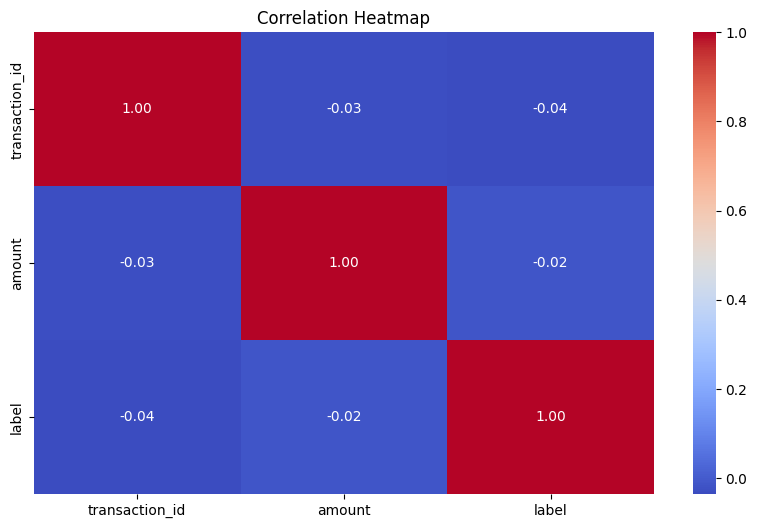

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ====== 1. Load Data ======
df = pd.read_csv("/kaggle/input/fraud-detection-in-transactions-dataset/fraud_detection.csv")  # Ganti dengan nama file kamu
print(f"📊 Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")

# ====== 2. Basic Info ======
print("\n📋 Basic Info:")
print(df.info())

# ====== 3. Missing Values & Duplicate Rows Check ======
print("\n🔍 Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0])

print("\n🔍 Duplicate Rows:")
duplicate = df.duplicated().sum()
print(duplicate)

# ====== 4. Skewness Check ======
print("\n📈 Skewness Check:")
skewed_features = df.select_dtypes(include=['number']).apply(lambda x: x.skew()).sort_values(ascending=False)
print(skewed_features)

print("\n📌 Recommendation:")
for col, skew in skewed_features.items():
    if abs(skew) > 1:
        print(f"⚠️ {col} is highly skewed (skew={skew:.2f}). Suggest: Apply log or sqrt transform.")
    elif abs(skew) > 0.5:
        print(f"ℹ️ {col} is moderately skewed (skew={skew:.2f}). Transform optional.")
    else:
        print(f"✅ {col} is fairly symmetric (skew={skew:.2f}). No action needed.")

# ====== 5. Outlier Detection (IQR Method) ======
print("\n📦 Outlier Check (IQR Method):")
for col in df.select_dtypes(include=['number']):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_count = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    if outlier_count > 0:
        print(f"⚠️ {col}: {outlier_count} outliers detected.")
    else:
        print(f"✅ {col}: No significant outliers.")

# ====== 6. Correlation Analysis ======
print("\n🔗 Correlation Matrix (Top correlated pairs):")
correlation = df.corr(numeric_only=True)
cor_matrix = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()
top_corr = cor_matrix[(cor_matrix < 1) & (cor_matrix > 0.7)]
print(top_corr)

print("\n📌 Recommendation:")
for (f1, f2), corr_val in top_corr.items():
    print(f"⚠️ {f1} & {f2} have high correlation ({corr_val:.2f}). Suggest: Keep only one or apply dimensionality reduction (e.g., PCA).")

# ====== 7. Heatmap ======
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [3]:
df.head()

,transaction_id,amount,merchant_type,device_type,label
0,1,46.93,travel,tablet,0
1,2,301.01,groceries,desktop,0
2,3,131.67,others,tablet,0
3,4,91.29,electronics,desktop,0
4,5,16.96,others,mobile,0


In [4]:
# Preprocessing Transform
import numpy as np
df['amount_log'] = np.log1p(df['amount'])  # log transform

In [5]:
# One Hot Encoding data kategorikal non-ordinal
df_encoded = pd.get_dummies(df, columns=['merchant_type', 'device_type'], drop_first=True)

In [7]:
# SMOTE untuk imbalance data
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns=['label', 'transaction_id','amount'])  # drop label dan ID, untuk amount pakai amount_log
y = df_encoded['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# SMOTE untuk data train
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [8]:
# Training model XGBoost
from xgboost import XGBClassifier

model = XGBClassifier(scale_pos_weight=1, use_label_encoder=False, eval_metric='logloss')
model.fit(X_res, y_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

📊 Classification Report:

              precision    recall  f1-score   support

           0     0.9459    0.7368    0.8284       190
           1     0.0385    0.2000    0.0645        10

    accuracy                         0.7100       200
   macro avg     0.4922    0.4684    0.4465       200
weighted avg     0.9006    0.7100    0.7902       200



<Figure size 600x400 with 0 Axes>

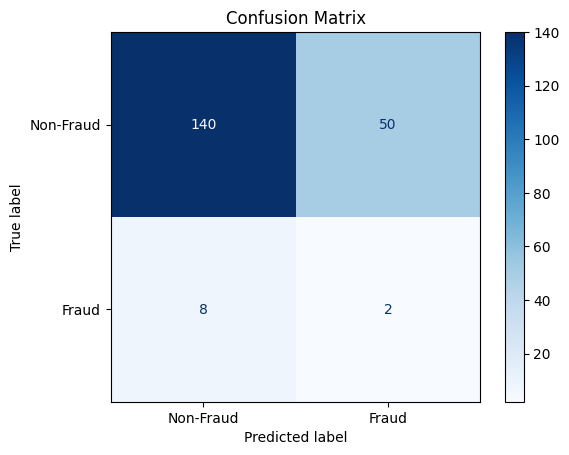

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Pastikan data test (X_test dan y_test) belum tersentuh SMOTE
y_pred = model.predict(X_test)

# 1. Laporan Klasifikasi
print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraud", "Fraud"])

# 3. Tampilkan Confusion Matrix
plt.figure(figsize=(6, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()
